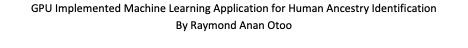

#Read vcf file from the 1000 genomes project

In [ ]:
## The reading and of the data from the 1000s genome's project was adopted from @LucilleWerner project on github as this was very helpful
import gzip
import pandas
import cudf
import cupy as cp

import pandas as pd
import numpy as np

vcf_file = "1000G_chr1_1-1000001.vcf"
vcf = open(vcf_file, 'r')

# if the VCF is big, we van prevent flooding the memory by reading the file line by line
go = True
while go:
    line = vcf.readline()
#     line = line.decode('utf-8')
    # this line contains the headers and also all the sample names
    if line.startswith('#C'):
        split_line = line.split('\t')

        samples = split_line[9:]
        samples[-1] = samples[-1].strip('\n')
        break

# sort samples on their ID
samples = sorted(samples)

# indexing the data frame on the sample names using pandas, this is convenient for merging later on
samples_idx = pandas.DataFrame(index=samples)


#indexing the data frame on the sample names using cuda's cudf
samples_idx1 = cudf.DataFrame(index=samples)

In [ ]:
#Find the distribution of the data to have a rough understanding of what features can be removed
samples.describe()

,rs367896724,rs540431307,rs555500075,rs548419688,rs568405545,rs534229142,rs537182016,rs572818783,rs538322974,rs376342519,...,rs565260701,rs115261610,rs371001401,rs184916420,rs150732520,rs546906682,rs139091112,rs538925052,rs112150631,rs189331984
count,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535,...,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535
unique,3,2,3,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,3,2
top,0|1,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,1|1,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
freq,1505,2529,2049,2534,2534,2534,2532,2534,2534,2499,...,2533,2513,2526,2529,2509,2533,2497,2533,2344,2509


In [ ]:
#load file containing top 100 snp predictive features
####  Here is a list of Ancestry Indicative Markers from literature that was selected to aid in the analysis
%time df = pd.read_csv('SNP_select.csv')
df.columns = ['snpID']
df.shape

df1 = df.values.tolist()
df2 = str(df1)
df2

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.97 ms


"[['rs2297679 '], ['rs7013027 '], ['rs733290 '], ['rs1844396'], ['rs1356733 '], ['rs152280'], [' rs2324909 '], ['rs4751629 '], ['rs1281340'], ['rs11164559 '], ['rs3128917 '], ['rs10188217 '], ['rs10872465 '], ['rs1467044 '], ['rs2172159 '], ['rs6583859 '], ['rs9960403 '], ['rs2441727 '], ['rs12777190 '], ['rs4706511 '], ['rs12759306 '], ['rs11097457 '], ['rs12594390 '], ['rs7646054 '], ['rs6012906 '], ['rs6050374 '], ['rs4785919'], [' rs156984 '], ['rs3943733 '], ['rs1512744 '], ['rs641902'], ['rs3816969'], [' rs6496173 '], ['rs4921809 '], ['rs250850'], ['rs4242165 '], ['rs1463652 '], ['rs12670839 '], ['rs2589655'], ['rs2303942 '], ['rs10505909 '], ['rs441517 '], ['rs7358335'], ['rs2427622 '], ['rs10746709 '], ['rs2276070 '], ['rs6681880'], ['rs2424303 '], ['rs3873386 '], ['rs4870268 '], ['rs867926'], ['rs7656234 '], ['rs3105439 '], ['rs2417680 '], ['rs4577244'], ['rs746124 '], ['rs9314379 '], ['rs10519410 '], ['rs11096674'], ['rs6741951 '], ['rs10497705 '], ['rs39108 '], ['rs4973190']

In [ ]:
%time samples_idx

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


""
HG00096
HG00097
HG00099
HG00100
HG00101
...
NA21137
NA21141
NA21142
NA21143


In [ ]:
%time samples_idx1

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


""
HG00096
HG00097
HG00099
HG00100
HG00101
...
HG00258
HG00259
HG00260
HG00261


In [ ]:
%time
# ignore SettingWithCopyWarning errors
pandas.options.mode.chained_assignment = None  # default='warn'
# file containing all the sample labels (the population codes)
popfile = "igsr_samples.tsv"

with open(popfile, 'r') as pop:
    pop_df = pandas.read_csv(pop, sep='\t', header=0)

# select the sample names and population codes to make a new data frame
pop_class = pop_df[['Sample name', 'Population code']]

# select the sample names and superpopulation codes to make a new data frame
superpop_class = pop_df[['Sample name','Superpopulation code']]

# set the sample names as index of pandas dataframe 
superpop_class.set_index('Sample name', inplace=True)
superpop_class.sort_index(inplace=True)

# create a new data frame by merging the label information with the existing sample IDs
feature_labels = samples_idx.join(superpop_class)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [ ]:
%time feature_labels

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


,Superpopulation code
HG00096,EUR
HG00097,EUR
HG00099,EUR
HG00100,EUR
HG00101,EUR
...,...
NA21137,SAS
NA21141,SAS
NA21142,SAS
NA21143,SAS


In [ ]:
class_ratios = feature_labels['Superpopulation code'].value_counts()
print(class_ratios)

AFR    669
EAS    515
EUR    505
SAS    494
AMR    352
Name: Superpopulation code, dtype: int64


In [ ]:
%time
import numpy as np

opened = open(vcf_file, 'r')

samples = samples_idx

cnt = 0
line = True
while line:
    line = opened.readline()

    if not line.startswith('#') and line.strip():
        # extract the sample genotypes from the row
        rs_id = line.split('\t')[2]
        alleles = line.split('\t')[9:]
        alleles[-1] = alleles[-1].strip('\n')

        # label missing data as NAN
        alleles = [x if not '.' in x.split('|') else np.NAN for x in alleles]
        
        # put the genotype info in certain order, i.e. the phasing is disregarded
        alleles = ['|'.join(sorted(x.split('|'))) for x in alleles if x is not np.NAN]
        
        # add the feature (SNP) to the existing data frame
        samples[rs_id] = alleles

        cnt += 1

opened.close()

# drop the columns (features) with NAN values
samples.dropna(axis=0, thresh=1, how="any", inplace=True)

# covert the categorical data (e.g. 1|0, 1|2) to numerical by one-hot-encoding
features_df = pandas.get_dummies(samples)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [ ]:
%time
import cupy as cp

opened = open(vcf_file, 'r')

samples = samples_idx

cnt = 0
line = True
while line:
    line = opened.readline()

    if not line.startswith('#') and line.strip():
        # extract the sample genotypes from the row
        rs_id = line.split('\t')[2]
        alleles = line.split('\t')[9:]
        alleles[-1] = alleles[-1].strip('\n')

        # label missing data as NAN
        alleles = [x if not '.' in x.split('|') else cp.NAN for x in alleles]
        
        # put the genotype info in certain order, i.e. the phasing is disregarded
        alleles = ['|'.join(sorted(x.split('|'))) for x in alleles if x is not cp.NAN]
        
        # add the feature (SNP) to the existing data frame
        samples[rs_id] = alleles

        cnt += 1

opened.close()

# drop the columns (features) with NAN values
samples.dropna(axis=0, thresh=1, how="any", inplace=True)

# covert the categorical data (e.g. 1|0, 1|2) to numerical by one-hot-encoding
features_df1 = pandas.get_dummies(samples)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [ ]:
%timeit features_df1

16.5 ns ± 0.0233 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


# Compare the time it takes to covert the categorical data (e.g. 1|0, 1|2) to numerical by one-hot-encoding by the CPU and GPU.

In [ ]:
#%time
import pandas
import pandas as pd

%timeit pandas.get_dummies(samples)

11.4 s ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#%time
import cudf
import pandas
import pandas as pd

features_dff = pandas.get_dummies(samples)
gdf = cudf.DataFrame.from_pandas(features_dff)
%timeit cudf.get_dummies(gdf)


1.17 s ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
features_df = cudf.get_dummies(gdf)

# Can be observed that  the GPU considerably outperformed the CPU in terms if computational time
# With the CPU (11.6 s ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) and GPU(1.16 s ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
#Same time as CPU here because it is only returning the dataframe(variable)
%timeit features_df

19.2 ns ± 0.0313 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [ ]:
################################################################ Random Forest Implementation using cuML #########################################################################
########################################################################### That for CPU runs ####################################################################################
############################################################################# needs some fixes ###################################################################################

In [ ]:
import cuml
import cupy as cp

In [ ]:
## NB NOT fully fuctional and can be skipped. Does not affect the rest of the algorithms

%time
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split

from cuml.datasets.classification import make_classification
from cuml.preprocessing.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.metrics import accuracy_score


features = cp.array(features_df1)
labels = cp.array(feature_labels).ravel()


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=42)

#################################################################################################################################################################################



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


ValueError: Unsupported dtype object

In [ ]:
############################################################################ CPU implementation of RF ###########################################################################

In [ ]:
%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = np.array(features_df)


labels = np.array(feature_labels).ravel()

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=42)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [ ]:
# do hyperparameter tuning on with RandomForestClassifier on our data set
%time
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
param_grid = { "criterion" : ["gini", "entropy"] , "min_samples_leaf" : [1,20,25,50], "min_samples_split" : [2,12,25], "n_estimators": [500, 1000, 1500]}

from sklearn.model_selection import GridSearchCV, cross_val_score

# define random forest model
rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=42, n_jobs=-1)
# method to test out all the combinations of the parameters
clf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, return_train_score=True)

# fit the features and labels 
clf.fit(train_features, train_labels)
# print the best parameters
clf.best_params_

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
#From the hyper-parametric tuning the above parameters were found to be the best combination of parameters to yield the best results for Random Forest classifier.
#****************************************************************'criterion': 'gini',***********************************************************************************
#****************************************************************'min_samples_leaf': 1,*********************************************************************************
#****************************************************************'min_samples_split': 2,******************************************************************************** 
#****************************************************************'n_estimators': 500} **********************************************************************************


#Model is defined with the parameters from the hyperparametric tunning 
#kept trying different n_estimators to achieve a better model.

rf = RandomForestClassifier(n_estimators=1500, criterion='gini', min_samples_leaf=1, min_samples_split=12, max_features='auto', oob_score=True, random_state=42, n_jobs=-1)

In [ ]:
# Use traditional train-test-split to compare with K-fold cross validation baseline and make classification report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

feature_list = features_df.columns


# print dimensions to check if all is ok
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

train_labels = train_labels.ravel()

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

Training Features Shape: (1901, 29762)
Training Labels Shape: (1901,)
Testing Features Shape: (634, 29762)
Testing Labels Shape: (634,)


In [ ]:
# print scores and classification report

# change dimension of labels to compute accuracy
test_labels = test_labels.ravel()
accuracy = accuracy_score(test_labels, predictions)

print('accuracy: {}'.format(round(accuracy, 4)))

# print score ()
score = rf.score(train_features, train_labels)
print('score: {}'.format(round(score, 4)))

# print classification report
print(classification_report(test_labels, predictions))


accuracy: 0.3596
score: 0.979
              precision    recall  f1-score   support

         AFR       0.36      0.71      0.48       152
         AMR       0.27      0.05      0.08        87
         EAS       0.37      0.16      0.23       142
         EUR       0.34      0.44      0.39       117
         SAS       0.39      0.30      0.34       136

    accuracy                           0.36       634
   macro avg       0.35      0.33      0.30       634
weighted avg       0.35      0.36      0.32       634



In [ ]:
#Feature selection. From the initial poor results obtained a closer detail to the data will reveal that is has too many features and as such 
#that has resulted in a lot of noise. It is thus imperative, from this, to remove the unimportant features(noise) in order to increase the performace 
#of the model. A threshold of the top 100 features (SNPs) were subsetted and used to retrain the model
# using a Univariate selection method and selectk class from the sciKit library

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions

In [ ]:
X = train_features
Y = train_labels

# feature extraction
test = SelectKBest(score_func=f_classif, k=700)
fit = test.fit(X, Y)

# summarize scores
set_printoptions(precision=3)
print(fit.scores_)

#Prints the index of the features that were selected as important
print(fit.get_support(indices=True))

features = fit.transform(X)


#Reduce X to the selected features
selected_Features = fit.transform(X)

#Reduce the test set to contain only the selected features as well
selected_Features_Test = fit.transform(test_features)

print(selected_Features)

selected_Features.shape
selected_Features_Test.shape



[ 8.147 11.135  2.794 ...  1.722  1.404  1.405]
[   79    80   166   167   168   249   250   292   329   330   367   368
   396   397   455   456   724   886   887   990  1291  1292  1307  1482
  1634  1719  1981  1982  1983  2101  2102  2295  2773  2928  2929  3210
  3212  3877  3879  4170  4191  4193  4764  4765  4835  4836  4988  5088
  5091  5092  5125  5126  5214  5327  5328  5352  5353  5402  5417  5419
  5540  5541  5626  5627  5665  5898  5899  6141  6142  6151  6187  6188
  6444  6572  6574  6971  7205  7206  7232  7233  7243  7244  7307  7308
  7334  7335  7363  7364  7368  7369  7383  7384  7388  7458  7459  7505
  7506  7600  7615  7616  7723  7724  7725  7776  7778  7808  7810  7840
  7847  7893  7898  7905  7907  7914  7943  7946  7957  7982  8025  8082
  8088  8103  8124  8174  8176  8186  8193  8200  8216  8267  8338  8393
  8409  8436  8438  8439  8485  8487  8529  8532  8535  8542  8590  8747
  8749  8875  8877  9104  9165  9166  9421  9509  9515  9516  9538  9539
  9

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [   57    58   124 ... 29740 29751 29752] are constant.
  UserWarning)
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(634, 700)

In [ ]:
################################################# Redo hyperparametric tuning since the feature size has been drastically reduced ################################################

# do hyperparameter tuning on with RandomForestClassifier on our data set
%time
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
param_grid = { "criterion" : ["gini", "entropy"] , "min_samples_leaf" : [1,20,25,50], "min_samples_split" : [2,12,13,15,25], "n_estimators": [500, 750,900, 1000, 1500, 2000]}

from sklearn.model_selection import GridSearchCV, cross_val_score

# define random forest model
rf_1 = RandomForestClassifier(max_features='auto', oob_score=True, random_state=42, n_jobs=-1)

# method to test out all the combinations of the parameters
clf_1 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, return_train_score=True)

# fit the features and labels 
clf_1.fit(selected_Features, train_labels)
# print the best parameters
clf_1.best_params_

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 750}

In [ ]:
rf_1 = RandomForestClassifier(n_estimators=750, criterion='entropy', min_samples_leaf=1, min_samples_split=12, max_features='auto', oob_score=True, random_state=42, n_jobs=-1)

In [ ]:
####################################################################### Re-Run RF Model with selected Features ###################################################################

rf_1 = RandomForestClassifier(n_estimators=500, criterion='gini', min_samples_leaf=1, min_samples_split=12, max_features= 100, oob_score=True, random_state=42, n_jobs=-1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#feature_list = features_df.columns

train_labels = train_labels.ravel()

# Train the model on training data
rf_1.fit(selected_Features, train_labels)

# Use the forest's predict method on the test data
predictions_1 =rf_1.predict(selected_Features_Test)


# print dimensions to check if all is ok
print('Training Features Shape:', selected_Features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', selected_Features_Test.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (1901, 700)
Training Labels Shape: (1901,)
Testing Features Shape: (634, 700)
Testing Labels Shape: (634,)


In [ ]:
# print scores and classification report

# change dimension of labels to compute accuracy
test_labels = test_labels.ravel()
accuracy = accuracy_score(test_labels, predictions_1)

print('accuracy: {}'.format(round(accuracy, 4)))

# print score ()
score = rf_1.score(selected_Features, train_labels)
print('score: {}'.format(round(score, 4)))

# print classification report
print(classification_report(test_labels, predictions_1))


accuracy: 0.3549
score: 0.9158
              precision    recall  f1-score   support

         AFR       0.36      0.66      0.46       152
         AMR       0.24      0.10      0.15        87
         EAS       0.42      0.22      0.29       142
         EUR       0.33      0.40      0.36       117
         SAS       0.38      0.28      0.32       136

    accuracy                           0.35       634
   macro avg       0.35      0.33      0.32       634
weighted avg       0.36      0.35      0.33       634



In [ ]:
#Multinomial Naïve Bayes 
import numpy as np
#rng = np.random.RandomState(1)
#X = rng.randint(5, size=(6, 100))
#y = np.array([1, 2, 3, 4, 5, 6])

from sklearn.naive_bayes import MultinomialNB

MNBclf = MultinomialNB()
MNBclf.fit(selected_Features, train_labels)

print((MNBclf.predict(selected_Features_Test)))
y_pred= MNBclf.predict(selected_Features_Test)

#check Accuracy score
from sklearn import metrics
metrics.accuracy_score(test_labels, y_pred)

#print('Model accuracy score: {0:0.4f}'. format(accuracy_score(selected_Features, y_pred)))


['AMR' 'EUR' 'AMR' 'AMR' 'AFR' 'AMR' 'SAS' 'AFR' 'AMR' 'AFR' 'AMR' 'AMR'
 'EUR' 'AMR' 'AMR' 'AMR' 'AMR' 'AFR' 'AMR' 'AMR' 'AMR' 'EUR' 'AFR' 'EUR'
 'AMR' 'EUR' 'EAS' 'AFR' 'AMR' 'EUR' 'AMR' 'EUR' 'AMR' 'AMR' 'EUR' 'EUR'
 'AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'SAS' 'EUR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR'
 'AMR' 'AMR' 'AMR' 'AMR' 'EUR' 'AMR' 'AFR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR'
 'AMR' 'EUR' 'AFR' 'AMR' 'AMR' 'AMR' 'AFR' 'SAS' 'AMR' 'AFR' 'EUR' 'AMR'
 'EAS' 'AMR' 'AMR' 'AMR' 'AFR' 'EUR' 'AMR' 'AMR' 'AFR' 'AMR' 'AMR' 'AMR'
 'AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'AFR' 'SAS' 'AMR' 'AMR' 'AMR' 'AMR'
 'EUR' 'EUR' 'AMR' 'AMR' 'SAS' 'SAS' 'AMR' 'EUR' 'AMR' 'AFR' 'AMR' 'AMR'
 'AMR' 'EUR' 'SAS' 'EUR' 'EUR' 'AMR' 'AMR' 'EUR' 'AMR' 'AMR' 'AMR' 'AMR'
 'AMR' 'EUR' 'EUR' 'AFR' 'EAS' 'EUR' 'AMR' 'SAS' 'AMR' 'EUR' 'AMR' 'EUR'
 'SAS' 'EUR' 'EUR' 'AMR' 'AMR' 'EUR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'EUR'
 'AMR' 'SAS' 'SAS' 'SAS' 'EUR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'EUR' 'AMR'
 'AMR' 'AFR' 'AMR' 'EUR' 'EUR' 'AMR' 'AFR' 'EAS' 'E

0.23501577287066247

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(test_labels, y_pred)

array([[18, 89,  6, 35,  4],
       [ 8, 67,  1,  7,  4],
       [12, 77,  4, 43,  6],
       [11, 47,  1, 52,  6],
       [17, 80,  3, 28,  8]])

In [ ]:
# Feature Extraction with PCA
import numpy
from pandas import read_csv
from sklearn.decomposition import PCA

# load data
X = train_features
Y = train_labels

# feature extraction
pca = PCA(n_components=1000)
fit = pca.fit(X)

# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [1.164e-01 4.786e-02 3.839e-02 3.389e-02 2.890e-02 2.136e-02 1.969e-02
 1.498e-02 1.466e-02 1.383e-02 1.261e-02 1.202e-02 1.136e-02 1.038e-02
 1.007e-02 9.617e-03 9.095e-03 8.758e-03 8.427e-03 8.119e-03 7.909e-03
 7.348e-03 6.846e-03 6.800e-03 6.539e-03 6.320e-03 6.168e-03 5.930e-03
 5.648e-03 5.221e-03 4.939e-03 4.771e-03 4.637e-03 4.430e-03 4.322e-03
 4.190e-03 4.096e-03 3.911e-03 3.790e-03 3.756e-03 3.647e-03 3.616e-03
 3.575e-03 3.413e-03 3.357e-03 3.305e-03 3.192e-03 3.136e-03 3.077e-03
 2.995e-03 2.901e-03 2.883e-03 2.843e-03 2.750e-03 2.744e-03 2.701e-03
 2.630e-03 2.576e-03 2.531e-03 2.505e-03 2.465e-03 2.413e-03 2.376e-03
 2.367e-03 2.339e-03 2.276e-03 2.205e-03 2.194e-03 2.157e-03 2.148e-03
 2.108e-03 2.080e-03 2.062e-03 2.035e-03 2.004e-03 1.994e-03 1.965e-03
 1.936e-03 1.925e-03 1.878e-03 1.845e-03 1.838e-03 1.830e-03 1.810e-03
 1.805e-03 1.767e-03 1.752e-03 1.738e-03 1.717e-03 1.692e-03 1.646e-03
 1.622e-03 1.612e-03 1.599e-03 1.574e-03 1.553e-03 1.543e

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERA

LR: 0.349264 (0.027394)
LDA: 0.315090 (0.036652)


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.342990 (0.034205)


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.268779 (0.028570)
NB: 0.243585 (0.034353)


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MNB: 0.267255 (0.024790)


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.377707 (0.024598)


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


ADA: 0.348242 (0.027576)


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

MLP: 0.335616 (0.022219)


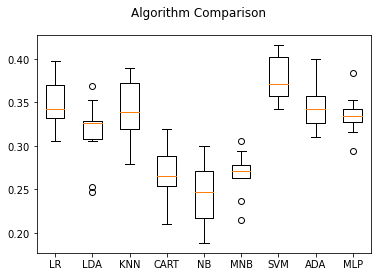

In [ ]:
#Try using several differnt models to see if any will lend support for the data under consideration

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# load dataset
X = selected_Features
Y = train_labels


# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('SVM', SVC()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('MLP', MLPClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [ ]:
#Multilayer perceptron 
#Multilayer perceptron 
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)

# load dataset
X = selected_Features
Y = train_labels

#with all data
#X = train_features
#Y = train_labels

mlp.fit(selected_Features,train_labels)


predict_train = mlp.predict(selected_Features)
predict_test = mlp.predict(selected_Features_Test)

# The accuracy and the F1 score is around 0.61 and 0.59, respectively.Ideally, the perfect model will have the value of 1 for both these metrics, which is however, nearly impossible in practice

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(train_labels,predict_train))

print("This Shows the performance of the model on the training data")
print(classification_report(train_labels,predict_train))

[[459  11  27  14   6]
 [154  21  16  18  56]
 [ 87   6 211   6  63]
 [117   8  19 172  72]
 [ 68  15  91  20 164]]
This Shows the performance of the model on the training data
              precision    recall  f1-score   support

         AFR       0.52      0.89      0.65       517
         AMR       0.34      0.08      0.13       265
         EAS       0.58      0.57      0.57       373
         EUR       0.75      0.44      0.56       388
         SAS       0.45      0.46      0.46       358

    accuracy                           0.54      1901
   macro avg       0.53      0.49      0.47      1901
weighted avg       0.54      0.54      0.51      1901



In [ ]:
print(confusion_matrix(test_labels,predict_test))
print(classification_report(test_labels,predict_test))

[[95  8 28 12  9]
 [48  2 17  2 18]
 [64  2 37 12 27]
 [41  4 21 26 25]
 [45  3 26 14 48]]
              precision    recall  f1-score   support

         AFR       0.32      0.62      0.43       152
         AMR       0.11      0.02      0.04        87
         EAS       0.29      0.26      0.27       142
         EUR       0.39      0.22      0.28       117
         SAS       0.38      0.35      0.37       136

    accuracy                           0.33       634
   macro avg       0.30      0.30      0.28       634
weighted avg       0.31      0.33      0.30       634



In [ ]:
###################################### Tune the model using GridSearchCV #################################

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)

#Define a hyper-parameter space to search. (All the values that you want to try out
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


In [ ]:
from sklearn.model_selection import GridSearchCV

#cv is the number of splits for cross validation Jobs defines the cpu resources to be used
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)

# load dataset
X = selected_Features
Y = train_labels

clf.fit(selected_Features, train_labels)

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
# NB This above step in the tuning process took a while to run.

# Best parameters found:
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'

In [ ]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.335 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.342 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.328 (+/-0.019) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.321 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.317 (+/-0.023) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.316 (+/-0.049) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam

In [ ]:
######################  Rerun the Neural network with the selected parameters #############################
y_true, y_pred = test_labels , clf.predict(selected_Features_Test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

         AFR       0.33      0.43      0.37       152
         AMR       0.20      0.17      0.19        87
         EAS       0.35      0.35      0.35       142
         EUR       0.36      0.32      0.34       117
         SAS       0.37      0.31      0.34       136

    accuracy                           0.33       634
   macro avg       0.32      0.32      0.32       634
weighted avg       0.33      0.33      0.33       634



In [ ]:
### SVM 
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=5)
svclassifier.fit(train_features, train_labels)


In [ ]:
#train_features, test_features, train_labels, test_labels
y_pred1 = svclassifier.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

print(confusion_matrix(test_labels,y_pred1))
print(classification_report(test_labels,y_pred1))

[[72 22 24 20 14]
 [28 21 12 15 11]
 [42 14 43 26 17]
 [31 11 15 48 12]
 [35 21 26 17 37]]
              precision    recall  f1-score   support

         AFR       0.35      0.47      0.40       152
         AMR       0.24      0.24      0.24        87
         EAS       0.36      0.30      0.33       142
         EUR       0.38      0.41      0.40       117
         SAS       0.41      0.27      0.33       136

    accuracy                           0.35       634
   macro avg       0.35      0.34      0.34       634
weighted avg       0.35      0.35      0.34       634



# References
# 1.Machine Learning with Neural Networks Using scikit-learn https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn
# 2. How to adjust the hyperparameters of MLP classifier to get more perfect performance https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
